# FYS5555 2020

## Final Project: ATLAS Open Data

## «Classification of Higgs production mechanism based on Hγγ dataset»



## Data investigation. Higgs di-photon peak

Event selection based on https://arxiv.org/abs/1802.04146

The goal of this chapter is to practice in extracting data from root files provided by ATLAS OpenData. Fully pythonic approach implemented here could serve as a proof of concept, that flexibility of python zoo of libraries can be exploited fully without loss of the efficiency in data processing.

In [1]:
import os
import time

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt

import uproot

In [2]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/data/"

For the analysis we preserve directory structure from OpenData archives. Monte carlo datasets carry a label that will be useful in the next chapters, where we are going to build classifier for differentiating production mechanisms of the Higgs boson at LHC.

In [3]:
datasets = {
    "GamGam": {
        "Data": [
            "data_A.GamGam",
            "data_B.GamGam",
            "data_C.GamGam",
            "data_D.GamGam"
        ],
        "MC": [
            ("mc_341081.ttH125_gamgam.GamGam", {"tag": "tt"}),
            ("mc_343981.ggH125_gamgam.GamGam", {"tag": "gg"}),
            ("mc_345041.VBFH125_gamgam.GamGam", {"tag": "VBF"}),
            ("mc_345318.WpH125J_Wincl_gamgam.GamGam", {"tag": "Wp"}),
            ("mc_345319.ZH125J_Zincl_gamgam.GamGam", {"tag": "Z"})

        ]
    }
}

In [4]:
def yield_files_with_meta(datasets, type_filter=None):
    if type_filter is None:
        type_filter = ["MC"]
    
    for process_name, process in datasets.items():
        print("Process: ", process_name)
        for type_name, thetype in process.items():
            print("Type: ", type_name)
            if type_name not in type_filter:
                continue
            for filedata in thetype:
                try:
                    filename, meta = filedata
                except ValueError:
                    filename = filedata
                    meta = {}
                print("File: ", filename)
                fullpath = os.path.join("root://", data_path, process_name, type_name, f"{filename}.root")
                yield (process_name, type_name, filename), fullpath

In [5]:
def dict_apply_mask(d, mask, fields=None):
    if fields is None:
        fields = d.keys()
    for f in fields:
        d[f] = d[f][mask]

In [6]:
def eta2tg_theta(eta):
    tg_theta = np.exp(-eta)
    tg_theta = 2*tg_theta**2/(1 - tg_theta**2)
    return tg_theta

In [7]:
def atlas_two_cosine(events, p1, p2):
    tg_theta_1 = eta2tg_theta(events[p1+b"_eta"])
    tg_theta_2 = eta2tg_theta(events[p2+b"_eta"])
    cos_delta_phi = np.cos(events[p2+b"_phi"] - events[p1+b"_phi"])
    return (cos_delta_phi + tg_theta_1*tg_theta_2)/np.sqrt((tg_theta_1**2 + 1)*(tg_theta_2**2 + 1))

We see the event features to be grouped into the categories:

* generic features: MET, triggers. weight...
* particle related features: `photon_*`, `lep_*`, `jet_*`, ...

Also we separate features in micro and macro features. Macro features are event wide and can be operated in a vectorized manner through the batch of events, while micro features depend on the particle content within the event. For instance, `photon_n` is a macro feature, each event has some number of photons, and `photon_pt` is a micro feature, because each of the `n` photons in the event has its own `pt`. At the same time, `photon_lead1_pt` is a `pt` for the leading photon, so it becomes "macro" again.

In the function below we apply cuts on event batch based on photon macro and micro features. Notice that there are no explicit loops over events in the batch, that is the power of numpy, that all the loops happen on the backend, powered by c++/fortran precompiled modules.

In [8]:
def photon_filter(events):
    # macro_mask = True
    
    macro_events = {}
    micro_events = {}
    
    macro_events[b"photon_n"] = events[b"photon_n"]
    n_threshold = macro_events[b"photon_n"] >= 2
    macro_mask = n_threshold
    
    micro_events[b"photon_pt"] = events[b"photon_pt"][n_threshold]
    micro_events[b"photon_eta"] = events[b"photon_eta"][n_threshold]
    micro_events[b"photon_phi"] = events[b"photon_phi"][n_threshold]
    micro_events[b"photon_E"] = events[b"photon_E"][n_threshold]
    micro_events[b"photon_isTightID"] = events[b"photon_isTightID"][n_threshold]
    micro_events[b"photon_trigMatched"] = events[b"photon_trigMatched"][n_threshold]
    micro_events[b"photon_ptcone30"] = events[b"photon_ptcone30"][n_threshold]
    micro_events[b"photon_etcone20"] = events[b"photon_etcone20"][n_threshold]
    
    
    pts = micro_events[b"photon_pt"].argsort(ascending=False)
    row_indices = np.arange(pts.shape[0])
    lead_pts = pts[:, 0]
    sublead_pts = pts[:, 1]
    
    
    macro_events[b"photon_n"] = macro_events[b"photon_n"][n_threshold]
    macro_events[b"photon_lead_pt"] = micro_events[b"photon_pt"][row_indices, lead_pts]
    macro_events[b"photon_lead_eta"] = micro_events[b"photon_eta"][row_indices, lead_pts]
    macro_events[b"photon_lead_phi"] = micro_events[b"photon_phi"][row_indices, lead_pts]
    macro_events[b"photon_lead_E"] = micro_events[b"photon_E"][row_indices, lead_pts]
    macro_events[b"photon_lead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, lead_pts]
    macro_events[b"photon_lead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, lead_pts]
    macro_events[b"photon_lead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, lead_pts]
    macro_events[b"photon_lead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, lead_pts]
    macro_events[b"photon_sublead_pt"] = micro_events[b"photon_pt"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_eta"] = micro_events[b"photon_eta"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_phi"] = micro_events[b"photon_phi"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_E"] = micro_events[b"photon_E"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, sublead_pts]
    
    macro_filter = (  (macro_events[b"photon_lead_pt"] > 25000)
                    &
                      (macro_events[b"photon_sublead_pt"] > 25000)
                    &
                      (macro_events[b"photon_lead_isTightID"])
                    &
                      (macro_events[b"photon_sublead_isTightID"])
                    &
                      (macro_events[b"photon_lead_trigMatched"])
                    &
                      (macro_events[b"photon_sublead_trigMatched"])
                    & 
                      (macro_events[b"photon_lead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_lead_etcone20"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_etcone20"] < 0.065)
                    & 
                      (  (np.absolute(macro_events[b"photon_lead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_lead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_lead_eta"]) < 2.37)
                         )
                      )
                    & (  (np.absolute(macro_events[b"photon_sublead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_sublead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_sublead_eta"]) < 2.37)
                         )
                      )
                   )
    
    dict_apply_mask(macro_events, macro_filter)
    macro_mask[macro_mask] = macro_filter

    macro_events[b"h_mass"] = np.sqrt(2.*macro_events[b"photon_lead_E"]
                                        *macro_events[b"photon_sublead_E"]
                                        *(1. - atlas_two_cosine(macro_events, b"photon_lead", b"photon_sublead"))
                                     )
    
    mass_cutoff =   (macro_events[b"photon_lead_E"]/macro_events[b"h_mass"] > 0.35) \
                  & (macro_events[b"photon_sublead_E"]/macro_events[b"h_mass"] > 0.25) \
                  & (macro_events[b"h_mass"] >= 105000.) \
                  & (macro_events[b"h_mass"] <= 160000)
    
    dict_apply_mask(macro_events, mass_cutoff)
    macro_mask[macro_mask] = mass_cutoff
    
    return macro_events, macro_mask
#photon_filter(test_events)

In addition to photon features, that are relevant for computing the Higgs boson mass, we also compute weights. We normalize weights to luminosity $1~pb^{-1}$, and rescale it later to the proper ATLAS OpenData luminosity.

In [9]:
def process_event_batch(events, bin_edges, weighted=False):
    filtered_photons, photon_macro_mask = photon_filter(events)
    h_masses = filtered_photons[b"h_mass"]/1000
    if weighted:
        total_weights = events[b"SumWeights"][0]
        x_section = events[b"XSection"][0]
        weights = (  events[b"mcWeight"]
                   * events[b'scaleFactor_PILEUP'] 
                   * events[b'scaleFactor_ELE'] 
                   * events[b'scaleFactor_MUON'] 
                   * events[b'scaleFactor_PHOTON'] 
                   * events[b'scaleFactor_TAU'] 
                   * events[b'scaleFactor_BTAG'] 
                   * events[b'scaleFactor_LepTRIGGER'] 
                   * events[b'scaleFactor_PhotonTRIGGER']
                  )[photon_macro_mask]/total_weights*x_section
    else:
        weights = None
    hist = np.histogram(h_masses, bin_edges, weights=weights, density=False)[0]
    return hist
#process_event_batch(test_events, bin_edges)

We are going to fill in the histogram between `105 GeV` and `160 GeV` with a binsize `1 GeV`.

In [10]:
bin_edges = np.linspace(105., 160., 55, dtype=np.float64)

In [11]:
def histogram_per_file(datasets, binedges, type_filter):
    entrysteps = 100000
    
    histograms = {}
    for (process, thetype, name), fullpath in yield_files_with_meta(datasets, type_filter):
        label = f"{process}:{thetype}:{name}"
        histograms[label] = np.zeros((bin_edges.shape[0] - 1,), dtype=np.float64)
        thehist = histograms[label]
        is_mc = ("mc" == thetype.lower())
        with uproot.open(fullpath) as f:
            total_events = f["mini"].numentries
            print("Total Num Events: ", total_events)
            time_start = time.perf_counter()
            time_now = time_start
            times = []
            for i, events in enumerate(f["mini"].iterate(["*"], entrysteps=entrysteps)):
                thehist += process_event_batch(events, bin_edges, weighted=is_mc)
                time_diff = time.perf_counter() - time_now
                time_now += time_diff
                times.append(time_diff)
                print("Processed: ", (i+1)*entrysteps, "; Time per batch: ", time_diff)
            print("Total time: ", time.perf_counter() - time_start, "; Median time per batch: ", np.median(times))
    return histograms

In [12]:
mc_hists = histogram_per_file(datasets, bin_edges, ["MC"])

Process:  GamGam
Type:  Data
Type:  MC
File:  mc_341081.ttH125_gamgam.GamGam
Total Num Events:  576491
Processed:  100000 ; Time per batch:  6.293894171016291
Processed:  200000 ; Time per batch:  1.9972253229934722
Processed:  300000 ; Time per batch:  1.8634532139985822
Processed:  400000 ; Time per batch:  2.002714964997722
Processed:  500000 ; Time per batch:  1.8058979299967177
Processed:  600000 ; Time per batch:  1.2022151520068292
Total time:  15.166532902017934 ; Median time per batch:  1.9303392684960272
File:  mc_343981.ggH125_gamgam.GamGam
Total Num Events:  1054711
Processed:  100000 ; Time per batch:  2.6116490270069335
Processed:  200000 ; Time per batch:  2.13506270799553
Processed:  300000 ; Time per batch:  1.2414860120043159
Processed:  400000 ; Time per batch:  1.8643696589861065
Processed:  500000 ; Time per batch:  2.124982950015692
Processed:  600000 ; Time per batch:  1.2132060430012643
Processed:  700000 ; Time per batch:  1.8917310500110034
Processed:  800000 

In [13]:
data_hists = histogram_per_file(datasets, bin_edges, ["Data"])

Process:  GamGam
Type:  Data
File:  data_A.GamGam
Total Num Events:  430344
Processed:  100000 ; Time per batch:  2.3173384759866167
Processed:  200000 ; Time per batch:  1.788156719005201
Processed:  300000 ; Time per batch:  1.668021237011999
Processed:  400000 ; Time per batch:  1.1781311229860876
Processed:  500000 ; Time per batch:  0.5277208290062845
Total time:  7.479961359989829 ; Median time per batch:  1.668021237011999
File:  data_B.GamGam
Total Num Events:  1528717
Processed:  100000 ; Time per batch:  1.9768924489908386
Processed:  200000 ; Time per batch:  33.71247603700613
Processed:  300000 ; Time per batch:  2.000965654005995
Processed:  400000 ; Time per batch:  13.202016113995342
Processed:  500000 ; Time per batch:  41.70850273699034
Processed:  600000 ; Time per batch:  21.285318457026733
Processed:  700000 ; Time per batch:  4.404384337976808
Processed:  800000 ; Time per batch:  3.935956977016758
Processed:  900000 ; Time per batch:  1.284366231993772
Processed: 

A nice observation, 100 000 events can be processed in 2 seconds. ~4 million events take 2 minutes to process. We could improve by increasing batch size because the major overhead is coming from data transport through xrootd. Moreover multithreading can be applied since analyses of batches are independent.

Below we show histograms collected per file with higgs mass at luminosity $1~pb^{-1}$. Then we add up all the data events to plot them later as data points, and we add up mc events to plot them on the same figure. Before plotting we show aggregated histograms rescaled to the proper luminosity.

In [14]:
mc_hists

{'GamGam:MC:mc_341081.ttH125_gamgam.GamGam': array([5.65047672e-10, 5.33132812e-10, 7.42442760e-10, 8.31777341e-10,
        1.08503467e-09, 1.26202288e-09, 1.36488520e-09, 1.40314810e-09,
        1.44317902e-09, 1.30233380e-09, 1.31511613e-09, 1.45692713e-09,
        1.51053814e-09, 1.22571531e-09, 1.56877888e-09, 1.30814759e-09,
        1.40515088e-09, 1.51306301e-09, 1.53389723e-09, 1.72799419e-09,
        1.60721370e-09, 1.50418034e-09, 1.52605328e-09, 1.37250433e-09,
        1.53223789e-09, 1.44953116e-09, 1.46806212e-09, 1.31678179e-09,
        1.32800437e-09, 1.27055211e-09, 1.08878773e-09, 1.26702115e-09,
        1.42401380e-09, 1.20324373e-09, 1.18552634e-09, 1.29262689e-09,
        1.16541488e-09, 1.32101130e-09, 1.12417897e-09, 1.16843069e-09,
        1.04343245e-09, 9.66566827e-10, 1.03113340e-09, 8.73426664e-10,
        6.99159397e-10, 9.66799529e-10, 9.15727494e-10, 8.73328077e-10,
        8.12461209e-10, 9.37107281e-10, 6.63745503e-10, 8.86183571e-10,
        9.96506877e-

In [15]:
data_hists

{'GamGam:Data:data_A.GamGam': array([16., 16., 11., 18., 12., 22., 13., 11., 18., 16.,  8., 10., 11.,
        10., 20., 13., 10., 11., 11., 14., 13.,  6., 13.,  9., 14.,  8.,
        10.,  4., 17.,  6., 10.,  7.,  8.,  8., 10., 12.,  4.,  5.,  9.,
         7.,  9., 11.,  8.,  8.,  6.,  7., 11.,  2.,  7.,  4.,  7.,  6.,
        11.,  1.]),
 'GamGam:Data:data_B.GamGam': array([67., 54., 57., 59., 48., 63., 63., 67., 48., 54., 49., 40., 36.,
        36., 48., 46., 44., 32., 50., 33., 53., 36., 35., 40., 32., 42.,
        36., 43., 25., 22., 41., 29., 35., 36., 39., 30., 22., 37., 25.,
        25., 28., 34., 20., 33., 25., 30., 32., 34., 21., 25., 23., 24.,
        23., 16.]),
 'GamGam:Data:data_C.GamGam': array([ 77.,  72., 109.,  86.,  82.,  79.,  70.,  68.,  67.,  79.,  78.,
         71.,  77.,  73.,  51.,  67.,  57.,  62.,  57.,  63.,  59.,  60.,
         46.,  56.,  58.,  34.,  56.,  51.,  45.,  51.,  53.,  46.,  45.,
         35.,  37.,  45.,  34.,  42.,  42.,  49.,  40.,  47.,  46.,

In [16]:
data_hist = sum(data_hists.values())

In [17]:
mc_hist = sum(mc_hists.values())

In [18]:
mc_hist.sum()

0.0028548804640280492

In [19]:
data_hist.sum()

10335.0

In [20]:
bin_mid = (bin_edges[1:] + bin_edges[:-1])/2
bin_size = (bin_edges[1:] - bin_edges[:-1])

We also define luminosity as $10.6~fb^{-1}$.

In [21]:
L = 1000*10.6

In [22]:
mc_hist

array([3.05333574e-05, 3.00460941e-05, 3.78323609e-05, 4.91625399e-05,
       6.40079338e-05, 8.08306654e-05, 9.18556917e-05, 9.06289060e-05,
       9.64228149e-05, 9.16975258e-05, 8.05620244e-05, 7.72050046e-05,
       7.77752220e-05, 7.49664418e-05, 7.49756071e-05, 7.19829877e-05,
       7.48831575e-05, 7.64063782e-05, 8.61777392e-05, 9.86811010e-05,
       9.95971071e-05, 9.08587675e-05, 8.70756016e-05, 7.78408090e-05,
       6.87876572e-05, 6.53229977e-05, 5.96813190e-05, 5.71000140e-05,
       5.40722332e-05, 5.09686597e-05, 4.54651885e-05, 4.46386669e-05,
       4.02029834e-05, 4.08897185e-05, 3.65384767e-05, 3.57063391e-05,
       3.11268353e-05, 3.23399281e-05, 2.80955408e-05, 2.85002227e-05,
       2.69467667e-05, 2.76266055e-05, 2.65649705e-05, 2.49880048e-05,
       2.36223611e-05, 2.36118681e-05, 2.42431755e-05, 2.13213950e-05,
       2.01761289e-05, 2.20927844e-05, 2.14198611e-05, 2.02449945e-05,
       2.14152430e-05, 1.91636858e-05])

In [23]:
data_hist

array([290., 292., 320., 297., 252., 310., 274., 260., 254., 265., 254.,
       238., 228., 235., 238., 223., 206., 217., 232., 214., 223., 178.,
       190., 197., 201., 175., 208., 180., 174., 167., 183., 165., 155.,
       166., 171., 156., 128., 145., 136., 139., 138., 160., 132., 140.,
       140., 124., 127., 142., 116., 129., 109., 119., 128.,  95.])

Finally we arrive to the plot with mass of Higgs boson computed from Higgs di-photon events and also datapoints. It turns out that most of the contribution to the data statistics constitute the background, but in MC data we have only signal datasets. That is why data does not match MC properly. Since the goal of this notebook was not the re-discovery of the Higgs, but acquaintance with data, features and relevant python libraries, we are going to wrap up here and follow to the next chapter. There we are going to make use of the workflow we've learned in this chapter and set up the feature processing pipeline for the production mechanism classification problem.

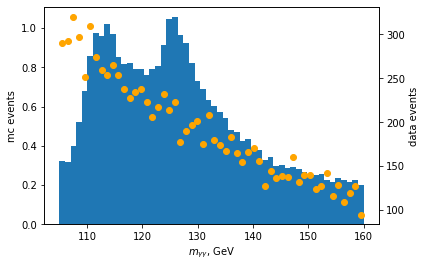

In [24]:
def plot_dat(ax, data_hist, mc_hist):
    ax.bar(bin_mid, mc_hist, width=bin_size, zorder=0)
    ax.set_ylabel("mc events")
    ax1 = ax.twinx()
    ax1.scatter(bin_mid, data_hist, zorder=1, color="orange")
    ax1.set_ylabel("data events")
    ax.set_xlabel("$m_{\gamma \gamma}$, GeV")
fig, ax = plt.subplots()
plot_dat(ax, data_hist, mc_hist*L)

In [25]:
test_mc = uproot.open(os.path.join("root://", data_path, "GamGam", "MC", f"{datasets['GamGam']['MC'][0][0]}.root"))

In [26]:
test_data = uproot.open(os.path.join("root://", data_path, "GamGam", "Data", f"{datasets['GamGam']['Data'][0]}.root"))

In [27]:
test_data["mini"].keys()

[b'runNumber',
 b'eventNumber',
 b'channelNumber',
 b'mcWeight',
 b'scaleFactor_PILEUP',
 b'scaleFactor_ELE',
 b'scaleFactor_MUON',
 b'scaleFactor_PHOTON',
 b'scaleFactor_TAU',
 b'scaleFactor_BTAG',
 b'scaleFactor_LepTRIGGER',
 b'scaleFactor_PhotonTRIGGER',
 b'trigE',
 b'trigM',
 b'trigP',
 b'lep_n',
 b'lep_truthMatched',
 b'lep_trigMatched',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_E',
 b'lep_z0',
 b'lep_charge',
 b'lep_type',
 b'lep_isTightID',
 b'lep_ptcone30',
 b'lep_etcone20',
 b'lep_trackd0pvunbiased',
 b'lep_tracksigd0pvunbiased',
 b'met_et',
 b'met_phi',
 b'jet_n',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_jvt',
 b'jet_trueflav',
 b'jet_truthMatched',
 b'jet_MV2c10',
 b'photon_n',
 b'photon_truthMatched',
 b'photon_trigMatched',
 b'photon_pt',
 b'photon_eta',
 b'photon_phi',
 b'photon_E',
 b'photon_isTightID',
 b'photon_ptcone30',
 b'photon_etcone20',
 b'photon_convType',
 b'tau_n',
 b'tau_pt',
 b'tau_eta',
 b'tau_phi',
 b'tau_E',
 b'tau_isTightID',
 b'tau_tru

In [28]:
test_mc_events = next(test_mc["mini"].iterate(entrysteps=10000))

In [29]:
        total_weights = test_mc_events[b"SumWeights"][0]
        x_section = test_mc_events[b"XSection"][0]
        weights = (  test_mc_events[b"mcWeight"]
                   * test_mc_events[b'scaleFactor_PILEUP'] 
                   * test_mc_events[b'scaleFactor_ELE'] 
                   * test_mc_events[b'scaleFactor_MUON'] 
                   * test_mc_events[b'scaleFactor_PHOTON'] 
                   * test_mc_events[b'scaleFactor_TAU'] 
                   * test_mc_events[b'scaleFactor_BTAG'] 
                   * test_mc_events[b'scaleFactor_LepTRIGGER'] 
                   * test_mc_events[b'scaleFactor_PhotonTRIGGER']
                  )/total_weights*x_section
        weights

array([-4.1094459e-12, -3.5343677e-12, -4.1031982e-12, ...,
       -1.8202724e-12, -3.4606558e-12,  2.8924742e-12], dtype=float32)

In [30]:
test_mc_events[b"XSection"][0]

2.6433863e-06

In [31]:
test_mc_events[b"SumWeights"][0]

485440.0